# Exercise: Association Rule Learning

#### Predicting clicks on KDD cup Dataset

### Introduction

The goal of this exercise is to implement assocition rule learning on the KDD Cup 2000 Dataset.

We will cover

- ~Q1: Calculate frequent itemsets for browsing history contained in KDD Cup Dataset, e.g. which sites are visited frequently after each other
- ~Q2: as Q1 but with sites-visited *and* products
- ~Q3: Mine for Association Rules between User Profiles and Purchase Probablity, e.g. Male Users over 40 who visit the page for a second time are very likely to make a purchase.

### KDD cup Dataset

TODO modify description

We have used KDD cup2012 track2 dataset for our evaluation.
There are total 6 data files

1. training.txt
2. queryid_tokensid.txt
3. userid_profile.txt
4. titleid_tokensid.txt
5. purchasedkeywordid_tokensid.txt
6. descriptionid_tokensid.txt

Please follow below link to check how different files are mapped to each other.

https://github.com/zieglerk/LODA-lecture-notes-on-data-analysis/blob/master/II.ML-and-DM/images/Kddcup_database.png

For below example we have worked on smaller dataset (first 100 records), we have merged training.txt and userid_profile.txt, please check below link to see the data.

https://github.com/zieglerk/LODA-lecture-notes-on-data-analysis/blob/master/II.ML-and-DM/Kddcup_data.txt


### Setting up IPython Notebook

The code below simply sets up ipython notebook and displays graphs inline (e.g. as HTML)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Preparation and Preprocessing

We will

- Load the data
- Clean the Data

#### Download and import the data

In [2]:
import os
path = os.path.join(os.path.expanduser('./'),'Kddcup_data.txt')#change this location according to your directory
#import numpy now and load the data set into a numpy array
import numpy as np
data = np.loadtxt(path)
data.shape

(811, 14)

In [4]:
feature = ['click','impressions','displayurl','adid','advertiserid','depth','position', 
           'queryid', 'keywordid', 'titleid','descriptionid','userid','gender','age']

In [5]:
#missing values are displayed as nan. lets take a look which columns there are
np.any(np.isnan(data),axis=0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [6]:
#lets take a look which rows are affected 
data_nan_rows = np.any(np.isnan(data),axis=1)
data[data_nan_rows,]

array([], shape=(0, 14), dtype=float64)

In [7]:
#lets remove nans 
data_wo_nan = data[~data_nan_rows,]
'removed %d items'%(data.shape[0]-data_wo_nan.shape[0])

'removed 0 items'

### Analysing the data set

Before applying data mining methods on an unknown data set, one should try to get some statistical description of the data set. A good method therefore is the boxplot


/home/sharma/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


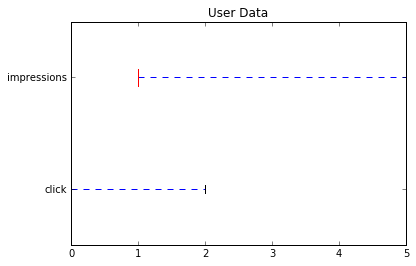

In [8]:
#Analysing the data set
fig = figure()
ax1 = fig.add_subplot(1,1,1)
ax1.boxplot(data_wo_nan[:,0:2],vert=False)
ax1.set_title("User Data")
ax1.set_yticklabels(feature[0:2])
fig.show()


### Implementing the linear model

Using Numpy this becomes pretty easy. We just have to implement the function

In [9]:
import numpy.linalg as la
def linreg(X,y,bias=True):
    """
    X: data matrix n rows, d columns
    Y: target values n rows, 1 column
    bias: if true, a bias term is included at the end of the weight vector
    return: parameter vector w
    """
    if bias:
        X = np.concatenate((X,-np.ones((X.shape[0],1))), axis=1)
    w = np.dot(np.dot(la.inv(np.dot(X.T,X)),X.T),y) #that is the model
    out = np.dot(X,w) # that is the models output 
    rss = np.sum((out-y)**2) #that is the residual sum of squares
    return (w,out,rss) #we pass back the vector, the output and the rss error

#### The Pseudoinverse

defines the so called pseudo-inverse (more specificall the Moore-Penrose Matrix Inverse, but why do we need that strange thing?

First of all, recall from you Linear Algebra class that the inverse only exists for squared matrices. This is not the case in our example. So a way to approximate the inverse for non-squared matrices is to use the above pseudo-inverse. But why?

We will get to this by an example. Consider that you have a one dimensional set of data points. Lets say you want to predict the miles-per-gallon based on the weight of the car, that is. So how many data points do you need for deriving the exact and ?

The answer is **2.** Given **2** data points you can uniquely find both parameters. Recall again from linear algebra that. forms a linear equation system with two parameters. Given a system of linear equations, we have three possibilities:

- **Determined: The number of equations (= the number of data points in our case) is the same as the number of parameters. **

    In this case, if there exists a unique solution we can find it by solving the linear equation system.

- **Underdetermined: You have less data points (= lower number of equations) than parameters**

If we have lets say 1 data point in our example above, than we can find an infinite amount of different solutions. The system of linear equations is underdetermined. This does not happen often in data mining, so we ignore the case. The data mining solution to this would be in getting more data or reducing the model.

- **Overdetermined: You have more data points than parameters**

If you have more data points than parameters, say 3, than you will have an **overdetermined** set of linear equations. That is what we often have in data analysis. So drilling further down we can distinguish between two cases again:

 1. There is one exact solution, satisfying all data points
 
 Like for example  . We can generate an infinite amount of data points, where the vector space for those data points is spanned by two basis vectors. In practice we are given the data and do not know the exact model. So it is unlikely that a linear model is the correct model. Moreover, while the linear model might be the correct model, measurements could be noisy. For example, measuring the weight of a car might not be perfectly exact to the last point beyond the comma. So it is unlikely, that we can find an exact solution.
 
 This case is in principal the same as the determined case. We can find a unique solution.
 
 2. There is no unique solution, i.e. not all data points can be predicted by the model
 
 This is the case we will see below. The model can not explain all the data, only parts of it. Our goal here is to find "the best solution", where best has to be specified. That brings me back to the pseudoinverse above. The pseudoinverse provides the solution with the minimum variance, i.e. squared difference. A different choice of the pseudoinverse yields a different "best" solution. This is the case solved by the linreg function (and of course it also finds the unique solution, if it exists)

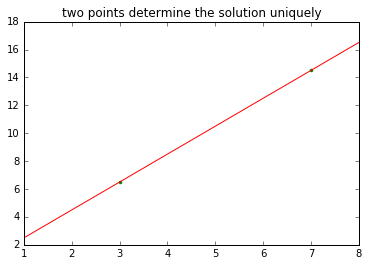

In [10]:
#the determined case, note that the data is one dimensional, because the last dimension is only the bias term
w=np.array([2, 0.5]).T
x=np.array([[3,1], [7,1]])
y=np.dot(x,w)
plot (x[:,0],y,'g.') #plot the data points
plot ([1,8],np.dot([[1,1],[8,1]],w),'r') #plot the line
title("two points determine the solution uniquely")
show()

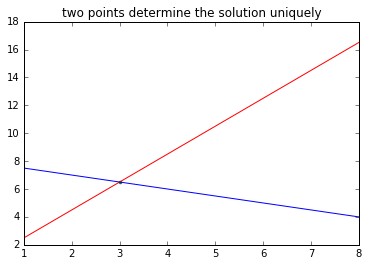

In [11]:
#the underdetermined case, note that the data is one dimensional, because the last dimension is only the bias term
w1=np.array([2, 0.5]).T #one correct solution
w2=np.array([-0.5, 8]).T #the second correct solution. in fact, infinit correct solutions exists
x=np.array([[3,1]])
y=np.dot(x,w1)
plot (x[:,0],y,'g.') #plot the data points
plot ([1,8],np.dot([[1,1],[8,1]],w1),'r') #plot solution w1
plot ([1,8],np.dot([[1,1],[8,1]],w2),'b') #plot solution w2. it also goes through the data point x
title("two points determine the solution uniquely")
show()

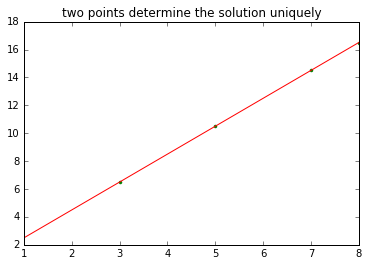

In [12]:
#the overdetermined case, with a unique solution
w1=np.array([2, 0.5]).T #one correct solution
x=np.array([[3,1],[5,1],[7,1],[8,1]])
y=np.dot(x,w1)
plot (x[:,0],y,'g.') #plot the data points
plot ([1,8],np.dot([[1,1],[8,1]],w1),'r') #plot solution w1
title("two points determine the solution uniquely")
show()

#### A first test

Now lets test it on a small example. We want to predict clicks(first feature) by depth und position (sixth and seventh feature)


In [13]:
#We want to predict clicks (first feature) by depth und position (sixth and seventh feature)
feature

['click',
 'impressions',
 'displayurl',
 'adid',
 'advertiserid',
 'depth',
 'position',
 'queryid',
 'keywordid',
 'titleid',
 'descriptionid',
 'userid',
 'gender',
 'age']

In [14]:
#calculate rss
X=data_wo_nan[:,5:7]
y=data_wo_nan[:,0]
(w,out,rss) = linreg(X,y)
rss


46.290252272947043

Works. But was does the RSS mean? In principal, it is the (squared) deviation of the linear model from the data, the discrpeancy of the data from the model. Other names are sum of squared errors of prediction (SSE).It is an unscaled (i.e. depending on the number of data points considerd) measure ofdispersion (also called vairability).

The RSS can be seen as a statistical variable measuring the deviation per data point. In order to get an **estimator of deviation per data point**, we can simply calculate the average RSS per data point. This is also known as the Mean Squared Error (or MSE).

In [15]:
#average rss per data point
mse = rss/(y.shape[0])
sqrt(mse)

0.23891001012574256

A intuitive interpretation of the Root-Mean-Square-Error, although not theoretical sound, is that on average we are ± 4.6 miles-per-gallon wrong with our model. The square root scales the error down to the unit of the attribute and hence allows propert interpretation

#### Predicting on single variables

Now lets analye the KDD cup data set and how good our regression is. We will first estimate a linear model from all single variables, plot the data plus the model and finally plot the MSE as summary


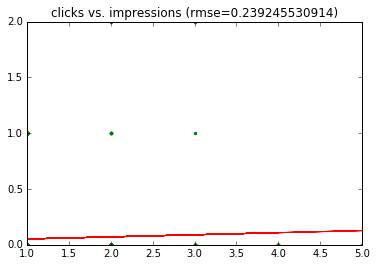

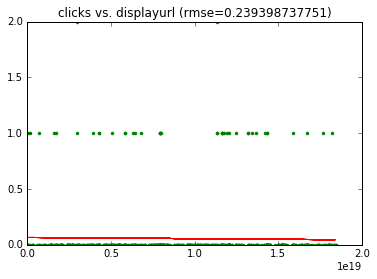

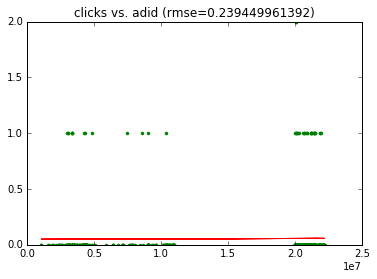

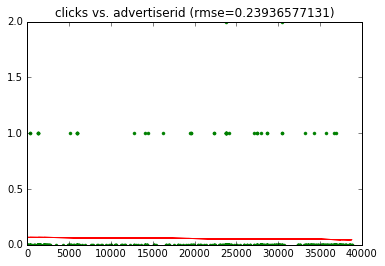

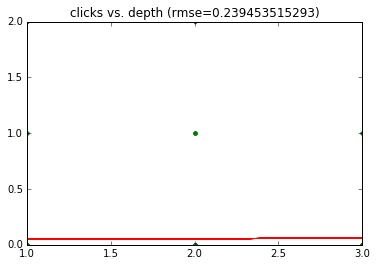

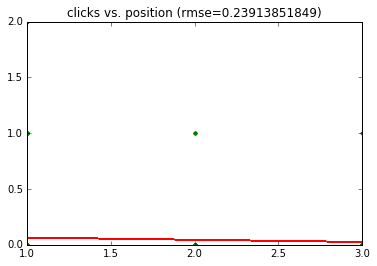

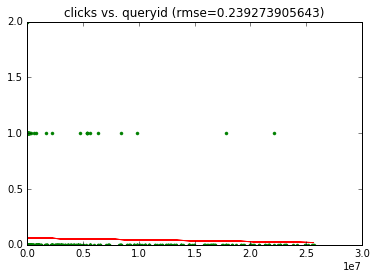

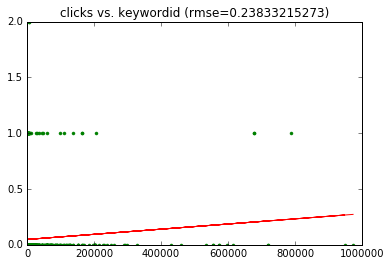

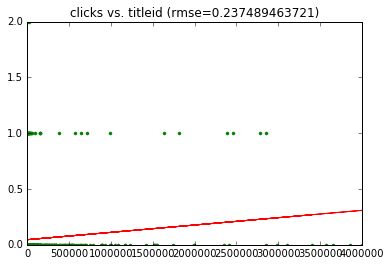

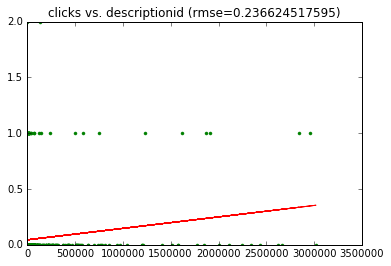

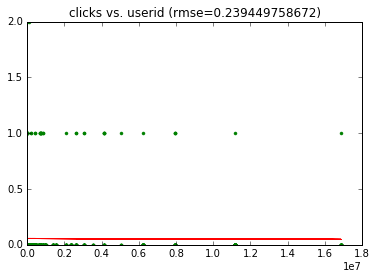

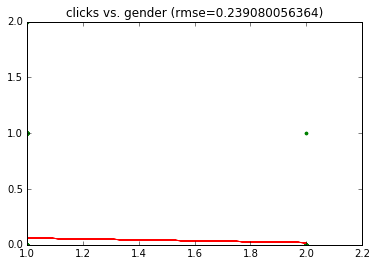

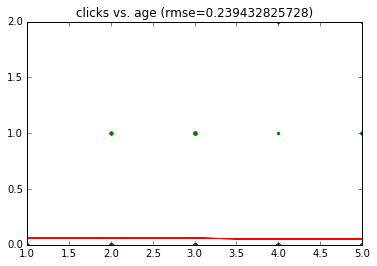

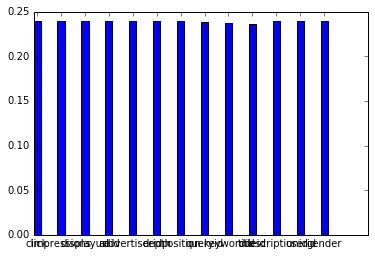

In [16]:
n_feat = data_wo_nan.shape[1]
rmses =[]

for i in range(1,n_feat):
    X=data_wo_nan[:,i:i+1] #i+1 is needed so that X stays a matrix
    y=data_wo_nan[:,0]
    (w,out,rss) = linreg(X,y)
    rmse = sqrt(rss/(y.shape[0]))
    plot(X,y,'g.')
    plot(X,out,'r')
    title('clicks vs. '+ feature[i] + ' (rmse='+str(rmse)+')')
    show()
    rmses.append(rmse)
# now plot MSE curve   
ind = np.arange(len(rmses))
width = 0.3
bar(ind,rmses,width, label= 'Root Mean Square Errors',)
xticks(ind+width/2., feature)
show()

#### Predicting on all variables

Extension to all variables is easy. We go from a 1D vector to a nD Matrix. Numpy handles the matrix calculation for us, so we just have to change the data. Since visualisation is not feasible, we have to rely on the MSE calculation.

In [17]:
#Predicting on all variables
X=data_wo_nan[:,1:8]
y=data_wo_nan[:,0]
(w,out,rss) = linreg(X,y)
rmse = sqrt(rss/(y.shape[0]))
"MSE for all features is %f"%(rmse)



'MSE for all features is 0.238360'